# <center>Data ingestion and EDA</center>

### Updated: April 13, 2023

### Background:

- ### The goal of this project is to perform semantic segmentation on drone image datasets. 


- ### We have two versions: the [official dataset](https://www.tugraz.at/index.php?id=22387) and the [kaggle version](https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset). 

    - ### <span style='color:blue'>Official dataset</span>: <span style='color:orange'>24 semantic classes</span>, high resolution 
    
    - ### <span style='color:blue'>Kaggle dataset</span> was derived from the official dataset, with lower resolution. It include two options. One is for <span style='color:orange'>binary segmentation</span>, the other is for <span style='color:orange'>multiclass (5 classes) segmentation</span>. 
            

### This notebook: 

- ### Simple visualization and EDA to get a better understanding of the image datasets.

### Overall workflow:

- ### We will start simple and focus on the binary segmentation of the Kaggle binary datasets. 

- ### We will then extend our model to the 5 classes and 24 classes segmentation. 

### Note

- ### The RGB information of the binary class 'landing_zone' provided by the [Kaggle dataset](https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset) is wrong. Fixed file 'colormaps.xlsx' can be found in the `data` folder.


---
<a id='section_t'></a>

<h2>Table of contents</h2>

- ### 0. [Basics](#section_0)

- ### 1. [Load datasets](#section_1) 
    - #### 1.1 [Official dataset](#section_1.1)
    
    - #### 1.2 [Kaggle dataset](#section_1.2)
    
    - #### 1.3 [Classes relationship between the official and the kaggle version](#section_1.3)

- ### 2. [Basic visualization](#section_2)

    - #### 2.1 [Class color labels](#section_2.1)
    
    - #### 2.2 [Paired images](#section_2.2)

- ### 3. [Data quality](#section_3)

    - #### 3.1 [Image size and aspect ratios](#section_3.1)
    
    - #### 3.2 [Class distributions](#section_3.2)

- ### 4. [Next steps](#section_4)

---
<a id='section_0'></a>

# 0 | Basics 


Back to [Table of contents](#section_t)

- ### Import libraries

In [1]:
import os
import ast
import random
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# OpenCV
import cv2

# Tensorflow
import tensorflow as tf

# colorama
from colorama import Fore, Back

# For utils
import inspect
import utils

- ### OpenCV version

In [2]:
cv2.__version__

'4.7.0'

- ### TensorFlow version

In [3]:
tf.__version__

'2.9.0'

- ### Set the random seed for reproducibility

In [4]:
random.seed(42)

- ### Paths of official dataset and kaggle derived datasets - `DIR`, `kaggle_DIR`

In [5]:
base_dir = os.getcwd()
DIR = os.path.join(base_dir, 'semantic_drone_dataset/')
kaggle_DIR = os.path.join(base_dir, 'semantic_drone_dataset_kaggle/')

- ### Paths of official images, labels - `RAW_DIR`, `LABEL_DIR`

In [6]:
RAW_DIR = os.path.join(DIR, 'training_set/images/')
LABEL_DIR = os.path.join(DIR, 'training_set/gt/semantic/label_images/')

- ### Dictionary of official datasets containing classes, r, g, b `official_dict`

In [7]:
official_dict = DIR+'training_set/gt/semantic/class_dict.csv'

- ### Paths of kaggle datasets (note that the binary and multi classes share the same raw files)

    - ### `kaggle_RAW_DIR`
    - ### `kaggle_LABEL_BINARY_DIR`
    - ### `kaggle_LABEL_MULTI_DIR`

In [8]:
kaggle_RAW_DIR=os.path.join(kaggle_DIR, 'binary_dataset/original_images/')
kaggle_LABEL_BINARY_DIR=os.path.join(kaggle_DIR, 'binary_dataset/images_semantic/')
kaggle_LABEL_MULTI_DIR=os.path.join(kaggle_DIR, 'classes_dataset/label_images_semantic/')

- ### Dictionary of kaggle dataset

    - ### `kaggle_dict`
    
    - ### `kaggle_info`

In [9]:
# Kaggle class dict
kaggle_dict = kaggle_DIR+'colormaps.xlsx'

# Kaggle data extension info
kaggle_info = kaggle_DIR+'classes_dict.txt'

### We have 599 paired images

In [10]:
!ls $RAW_DIR

000.jpg 062.jpg 122.jpg 174.jpg 230.jpg 294.jpg 348.jpg 423.jpg 476.jpg 540.jpg
001.jpg 063.jpg 123.jpg 175.jpg 232.jpg 295.jpg 349.jpg 424.jpg 478.jpg 543.jpg
002.jpg 065.jpg 124.jpg 176.jpg 233.jpg 296.jpg 351.jpg 425.jpg 479.jpg 544.jpg
003.jpg 068.jpg 126.jpg 177.jpg 234.jpg 298.jpg 355.jpg 426.jpg 480.jpg 545.jpg
004.jpg 070.jpg 128.jpg 178.jpg 235.jpg 299.jpg 356.jpg 427.jpg 484.jpg 549.jpg
005.jpg 071.jpg 130.jpg 179.jpg 236.jpg 301.jpg 361.jpg 428.jpg 485.jpg 551.jpg
006.jpg 073.jpg 133.jpg 180.jpg 237.jpg 302.jpg 363.jpg 429.jpg 488.jpg 554.jpg
008.jpg 074.jpg 134.jpg 181.jpg 238.jpg 303.jpg 366.jpg 430.jpg 489.jpg 556.jpg
011.jpg 075.jpg 135.jpg 182.jpg 239.jpg 304.jpg 367.jpg 431.jpg 491.jpg 558.jpg
013.jpg 077.jpg 136.jpg 185.jpg 240.jpg 305.jpg 372.jpg 433.jpg 493.jpg 559.jpg
014.jpg 078.jpg 137.jpg 186.jpg 243.jpg 306.jpg 373.jpg 434.jpg 494.jpg 560.jpg
015.jpg 079.jpg 138.jpg 188.jpg 244.jpg 309.jpg 375.jpg 435.jpg 497.jpg 561.jpg
016.jpg 080.jpg 139.jpg 190.jpg 246.jpg 

In [11]:
!ls $LABEL_DIR

000.png 062.png 122.png 174.png 230.png 294.png 348.png 423.png 476.png 540.png
001.png 063.png 123.png 175.png 232.png 295.png 349.png 424.png 478.png 543.png
002.png 065.png 124.png 176.png 233.png 296.png 351.png 425.png 479.png 544.png
003.png 068.png 126.png 177.png 234.png 298.png 355.png 426.png 480.png 545.png
004.png 070.png 128.png 178.png 235.png 299.png 356.png 427.png 484.png 549.png
005.png 071.png 130.png 179.png 236.png 301.png 361.png 428.png 485.png 551.png
006.png 073.png 133.png 180.png 237.png 302.png 363.png 429.png 488.png 554.png
008.png 074.png 134.png 181.png 238.png 303.png 366.png 430.png 489.png 556.png
011.png 075.png 135.png 182.png 239.png 304.png 367.png 431.png 491.png 558.png
013.png 077.png 136.png 185.png 240.png 305.png 372.png 433.png 493.png 559.png
014.png 078.png 137.png 186.png 243.png 306.png 373.png 434.png 494.png 560.png
015.png 079.png 138.png 188.png 244.png 309.png 375.png 435.png 497.png 561.png
016.png 080.png 139.png 190.png 246.png 

---
<a id='section_1'></a>

# 1 | Load Dataset 


Back to [Table of contents](#section_t)

---
<a id='section_1.1'></a>

## 1.1 Official dataset 

Back to [Table of contents](#section_t)

- ### Original and labeled images: `RAW_FILES` & `LABEL_FILES`

In [12]:
RAW_FILES = sorted(os.listdir(RAW_DIR))
LABEL_FILES = sorted(os.listdir(LABEL_DIR))

- ### Class names and RGB channels: `df_official_dict`

In [13]:
df_official_dict = pd.read_csv(official_dict)
df_official_dict

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


- ### Get `df_official_dict` column names

In [14]:
df_official_dict.columns

Index(['name', ' r', ' g', ' b'], dtype='object')

- ### Use the `utils.get_classes_RGB` to return class and colors lists

In [15]:
print(inspect.getdoc(utils.get_classes_RGB))

Obtain classes names and the corresponding RGB information

Parameters
-----------
df: dataframe
    contains information of the class names and the RGB information

col_class: string
    name of the df column of class names

col_R: string
    name of the df column of the red channel

col_G: string
    name of the df column of the green channel

col_B: string
    name of the df column of the blue channel

Returns
-----------
CLASSES: list of strings
    contains the class names

COLORS: list of nested lists
    each nested list contains R, G, B information corresponding to one class

DICT: dictionary 
    contains paired values of CLASSES and COLORS


In [16]:
CLASSES, COLORS, DICT = utils.get_classes_RGB(df_official_dict, 'name', ' r', ' g', ' b')

- ### `CLASSES` of official dataset

In [17]:
CLASSES

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

- ### `COLORS` of official dataset

In [18]:
COLORS

[[0, 0, 0],
 [128, 64, 128],
 [130, 76, 0],
 [0, 102, 0],
 [112, 103, 87],
 [28, 42, 168],
 [48, 41, 30],
 [0, 50, 89],
 [107, 142, 35],
 [70, 70, 70],
 [102, 102, 156],
 [254, 228, 12],
 [254, 148, 12],
 [190, 153, 153],
 [153, 153, 153],
 [255, 22, 96],
 [102, 51, 0],
 [9, 143, 150],
 [119, 11, 32],
 [51, 51, 0],
 [190, 250, 190],
 [112, 150, 146],
 [2, 135, 115],
 [255, 0, 0]]

- ### `DICT` of official dataset

In [19]:
DICT

{'unlabeled': [0, 0, 0],
 'paved-area': [128, 64, 128],
 'dirt': [130, 76, 0],
 'grass': [0, 102, 0],
 'gravel': [112, 103, 87],
 'water': [28, 42, 168],
 'rocks': [48, 41, 30],
 'pool': [0, 50, 89],
 'vegetation': [107, 142, 35],
 'roof': [70, 70, 70],
 'wall': [102, 102, 156],
 'window': [254, 228, 12],
 'door': [254, 148, 12],
 'fence': [190, 153, 153],
 'fence-pole': [153, 153, 153],
 'person': [255, 22, 96],
 'dog': [102, 51, 0],
 'car': [9, 143, 150],
 'bicycle': [119, 11, 32],
 'tree': [51, 51, 0],
 'bald-tree': [190, 250, 190],
 'ar-marker': [112, 150, 146],
 'obstacle': [2, 135, 115],
 'conflicting': [255, 0, 0]}

- ### Save `DICT`

In [20]:
with open(base_dir+"/data/DICT_official_CLASSES_COLORS.txt", "w") as f:
    json.dump(DICT, f)  # encode dict into JSON

---
<a id='section_1.2'></a>

## 1.2 Kaggle dataset

Back to [Table of contents](#section_t)


---
- ### Original and labeled images: 
    - ### `kaggle_RAW_FILES`
    - ### `kaggle_LABEL_BINARY_FILES`
    - ### `kaggle_LABEL_MULTI_FILES`

In [21]:
kaggle_RAW_FILES = sorted(os.listdir(kaggle_RAW_DIR))
kaggle_LABEL_BINARY_FILES = sorted(os.listdir(kaggle_LABEL_BINARY_DIR))
kaggle_LABEL_MULTI_FILES = sorted(os.listdir(kaggle_LABEL_MULTI_DIR))

- ### Class names and RGB channels: `df_kaggle_class`

In [22]:
df_kaggle_class = pd.read_excel(kaggle_dict)
df_kaggle_class

,Classes,R,G,B,Id,Unnamed: 5,Classes.1,R.1,G.1,B.1,Id.1,Unnamed: 11,Classes.2,R.2,G.2,B.2,Id.2
0,unlabeled,0,0,0,0,NaN,obstacles,155.0,38.0,182.0,0.0,NaN,obstacles,204.0,153.0,255.0,0.0
1,paved-area,128,64,128,1,NaN,water,14.0,135.0,204.0,1.0,NaN,landing-zones,0.0,153.0,153.0,1.0
2,dirt,130,76,0,2,NaN,soft-surfaces,124.0,252.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,grass,0,102,0,3,NaN,moving-objects,255.0,20.0,147.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,gravel,112,103,87,4,NaN,landing-zones,169.0,169.0,169.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
5,water,28,42,168,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,rocks,48,41,30,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,pool,0,50,89,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,vegetation,107,142,35,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,roof,70,70,70,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- ### `df_kaggle_class` column names

In [23]:
df_kaggle_class.columns

Index(['Classes', 'R', 'G', 'B', 'Id', 'Unnamed: 5', 'Classes.1', 'R.1', 'G.1',
       'B.1', 'Id.1', 'Unnamed: 11', 'Classes.2', 'R.2', 'G.2', 'B.2', 'Id.2'],
      dtype='object')

- ### Extract the `df_kaggle_multi_class` which contains the 5 grouped classes

In [24]:
df_kaggle_multi_class = df_kaggle_class[['Classes.1', 'R.1', 'G.1', 'B.1', 'Id.1']].iloc[0:5]
df_kaggle_multi_class.rename(columns={'Classes.1': 'Class', 'R.1': 'R', 'G.1': 'G', 'B.1': 'B', 'Id.1':'Id'}, inplace=True)
df_kaggle_multi_class

,Class,R,G,B,Id
0,obstacles,155.0,38.0,182.0,0.0
1,water,14.0,135.0,204.0,1.0
2,soft-surfaces,124.0,252.0,0.0,2.0
3,moving-objects,255.0,20.0,147.0,3.0
4,landing-zones,169.0,169.0,169.0,4.0


- ### Extract the `df_kaggle_binary_class` which contains the binary classes

In [25]:
df_kaggle_binary_class = df_kaggle_class[['Classes.2', 'R.2', 'G.2', 'B.2', 'Id.2']].iloc[0:2]
df_kaggle_binary_class.rename(columns={'Classes.2': 'Class', 'R.2': 'R', 'G.2': 'G', 'B.2': 'B', 'Id.2': 'Id'}, inplace=True)
df_kaggle_binary_class

,Class,R,G,B,Id
0,obstacles,204.0,153.0,255.0,0.0
1,landing-zones,0.0,153.0,153.0,1.0


- ### Use the `utils.get_classes_RGB` to return class and colors lists

In [26]:
kaggle_multi_CLASSES, kaggle_multi_COLORS, kaggle_multi_DICT = utils.get_classes_RGB(df_kaggle_multi_class, 'Class', 'R', 'G', 'B')
kaggle_binary_CLASSES, kaggle_binary_COLORS, kaggle_binary_DICT = utils.get_classes_RGB(df_kaggle_binary_class, 'Class', 'R', 'G', 'B')

- ### Save dictioinary `kaggle_binary_DICT`, `kaggle_multi_DICT`

In [27]:
kaggle_binary_DICT

{'obstacles': [204, 153, 255], 'landing-zones': [0, 153, 153]}

In [28]:
with open(base_dir+"/data/DICT_kaggle_binary_CLASSES_COLORS.txt", "w") as f:
    json.dump(kaggle_binary_DICT, f)  # encode dict into JSON

In [29]:
kaggle_multi_DICT

{'obstacles': [155, 38, 182],
 'water': [14, 135, 204],
 'soft-surfaces': [124, 252, 0],
 'moving-objects': [255, 20, 147],
 'landing-zones': [169, 169, 169]}

In [30]:
with open(base_dir+"/data/DICT_kaggle_multi_CLASSES_COLORS.txt", "w") as f:
    json.dump(kaggle_multi_DICT, f)  # encode dict into JSON

---
<a id='section_1.3'></a>
## 1.3 Classes relationship between the official and the kaggle version
Back to [Table of contents](#section_t)

### The [kaggle page](https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset) provides a 'classes_dict.txt' file, which contains the correspondence between the derived binary and grouped classes and the official classes. 

### Let's take a closer look at how the binary and grouped classes were derived. 

- ### Parse the `kaggle_info` file

In [31]:
with open(kaggle_info, 'r') as file:
    binary_and_grouped = file.read()

exec(binary_and_grouped)

- ### Binary classes

    - ### `obstacles`

    - ### `landing-zones`

In [32]:
binary_classes

{0: {0, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
 1: {1, 2, 3, 4, 9}}

In [33]:
for i in range(0,len(binary_classes)):
    print(' ')
    print(Back.YELLOW + Fore.BLACK + '----- Kaggle binary class: '+df_kaggle_binary_class['Class'][i]+' -----')
    for j in binary_classes[i]:
        print(Back.RESET + Fore.GREEN + CLASSES[j])

 
----- Kaggle binary class: obstacles -----
unlabeled
water
rocks
pool
vegetation
wall
window
door
fence
fence-pole
person
dog
car
bicycle
tree
bald-tree
 
----- Kaggle binary class: landing-zones -----
paved-area
dirt
grass
gravel
roof


---
- ### Grouped classes

    - ### `obstacles`
    
    - ### `water`
    
    - ### `soft-surfaces`
    
    - ### `moving-objects`
    
    - ### `landing-zones`

In [34]:
for i in range(0,len(grouped_classes)):
    print('')
    print(Back.YELLOW + Fore.BLACK + '----- Kaggle grouped class: '+df_kaggle_multi_class['Class'][i]+' -----')
    for j in grouped_classes[i]:
        print(Back.RESET + Fore.GREEN + CLASSES[j])


----- Kaggle grouped class: obstacles -----
unlabeled
rocks
wall
window
door
fence
fence-pole
ar-marker
obstacle
conflicting

----- Kaggle grouped class: water -----
water
pool

----- Kaggle grouped class: soft-surfaces -----
dirt
grass
tree
bald-tree
vegetation

----- Kaggle grouped class: moving-objects -----
dog
car
bicycle
person

----- Kaggle grouped class: landing-zones -----
paved-area
gravel
roof


---
<a id='section_2'></a>

# 2 | Basic visualization

Back to [Table of contents](#section_t)

---
<a id='section_2.1'></a>
## 2.1 Class color labels

Back to [Table of contents](#section_t)

- ### Use `utils.plot_class_colorlabel` to plot the colors of each class

In [35]:
print(inspect.getdoc(utils.plot_class_colorlabel))

Plot color chart of each semantic class

Parameters
----------
CLASSES: list of strings
    each string denote a class name
    for example, CLASSES = ['unlabeled', 'person']

COLORS: list of nested lists
    each nested list contains RGB information of one class
    for example, COLORS = [[0, 0, 0], [255, 255, 255]]

title: string
    title of the plot

Returns
----------
A matplotlib type color chart


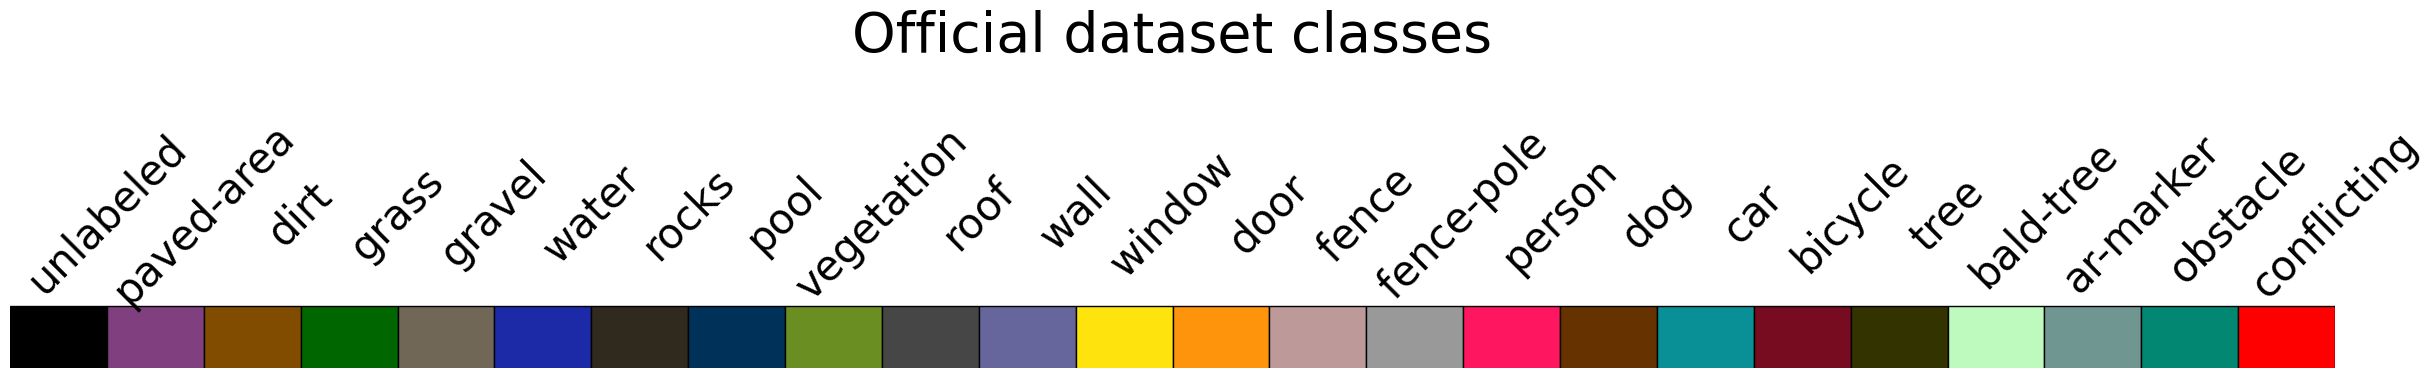

In [36]:
utils.plot_class_colorlabel(CLASSES, COLORS, 'Official dataset classes')

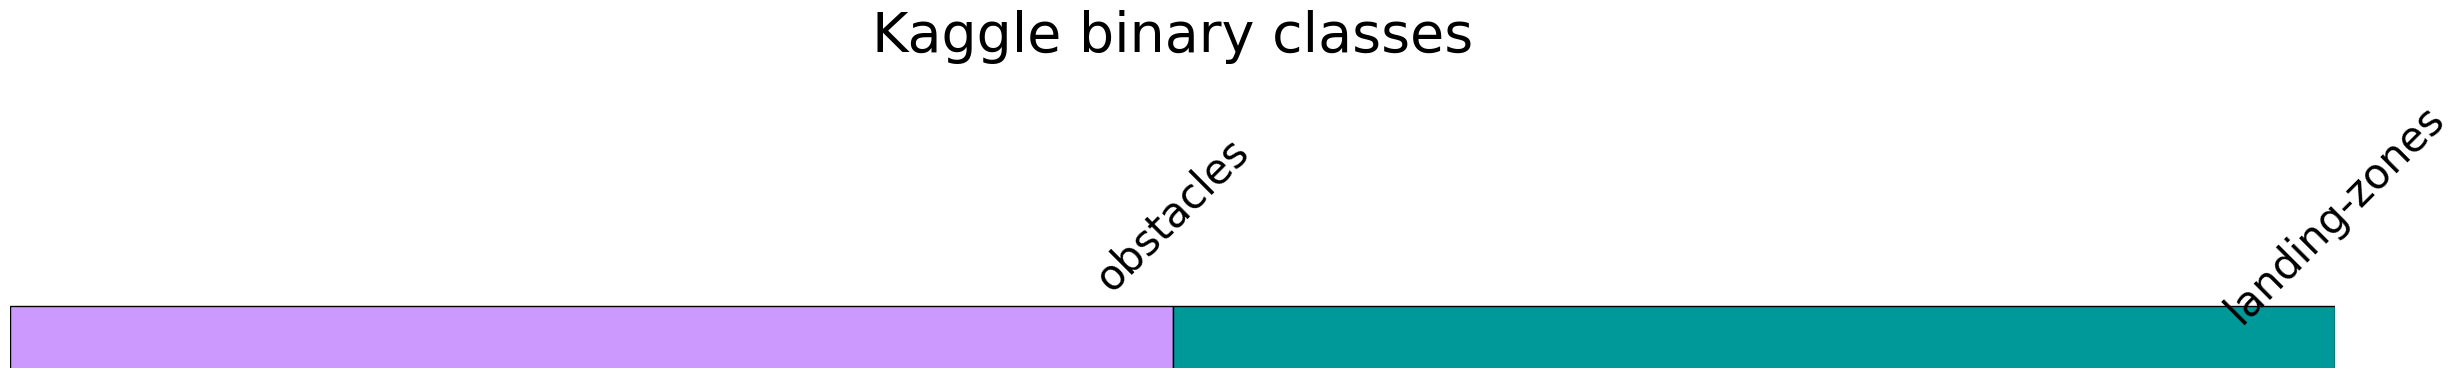

In [37]:
utils.plot_class_colorlabel(kaggle_binary_CLASSES, kaggle_binary_COLORS, 'Kaggle binary classes')

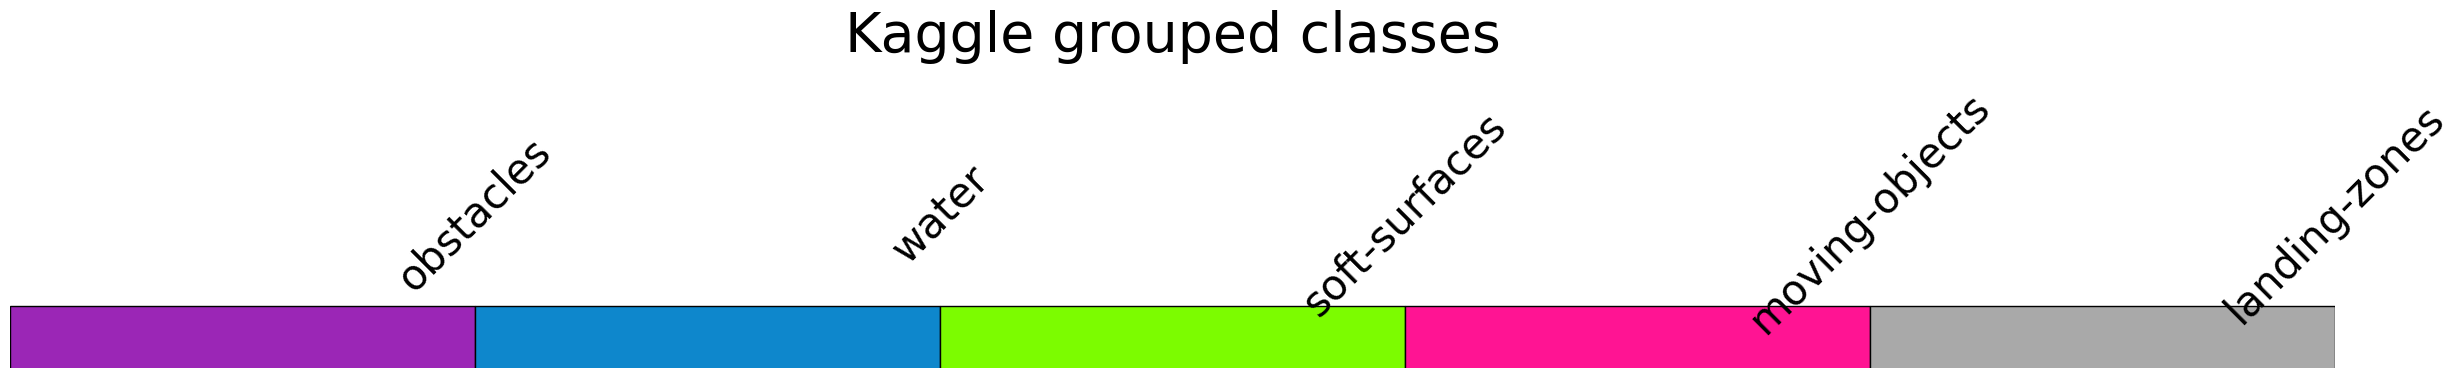

In [38]:
utils.plot_class_colorlabel(kaggle_multi_CLASSES, kaggle_multi_COLORS, 'Kaggle grouped classes')

---
<a id='section_2.2'></a>

## 2.2 Paired images

Back to [Table of contents](#section_t)

---
- ### Use `utils.panel_one_pair` to visualize one paired image

In [39]:
print(inspect.getdoc(utils.panel_one_pair))

Panel plot of one paried images

Parameters
-----------
raw_path: string
    folder path of the raw images
    
raw_file: string
    file name of the raw image 

labeled_path: string
    folder path of the labeled images
    
labeled_file: string
    file name of the labeled image
    
title: string
    title of the panel

Returns
-----------
Panel plot


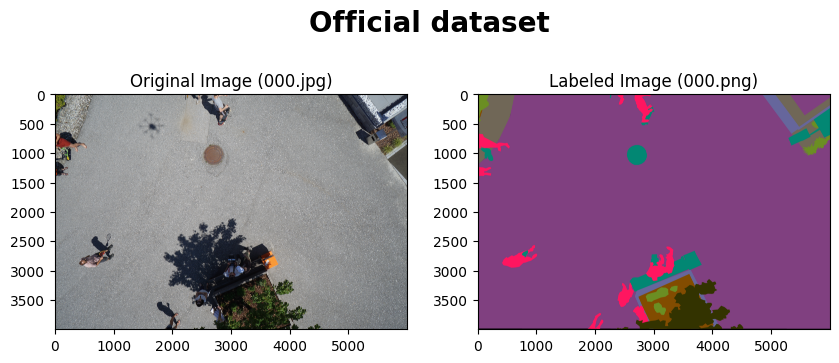

In [40]:
utils.panel_one_pair(RAW_DIR, '000.jpg', LABEL_DIR, '000.png', 'Official dataset')

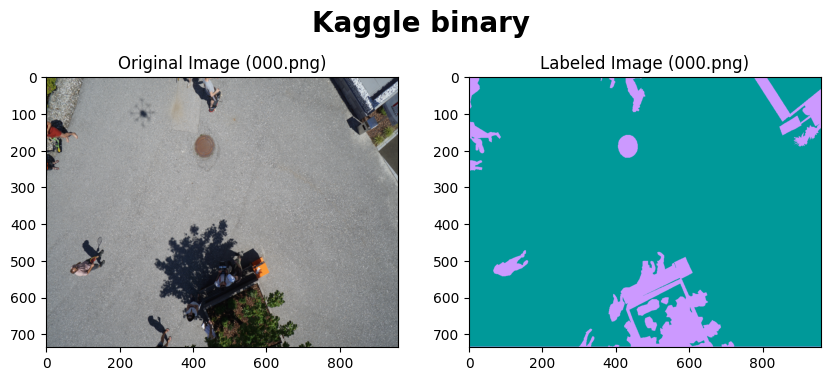

In [41]:
utils.panel_one_pair(kaggle_RAW_DIR, '000.png', kaggle_LABEL_BINARY_DIR, '000.png', 'Kaggle binary')

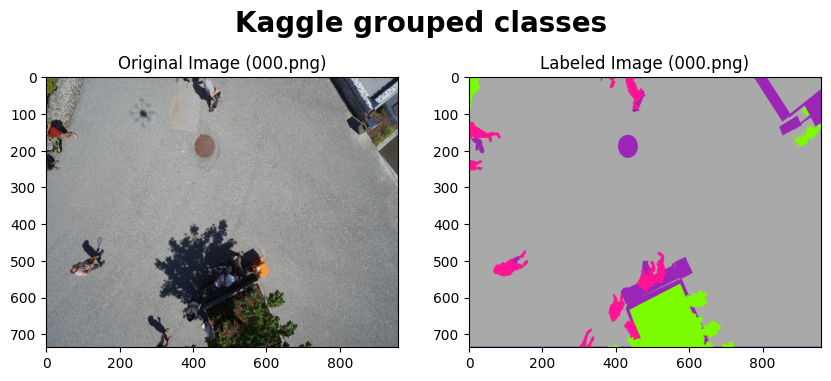

In [42]:
utils.panel_one_pair(kaggle_RAW_DIR, '000.png', kaggle_LABEL_MULTI_DIR, '000.png', 'Kaggle grouped classes')

- ### Let randomly select 5 paired images 

In [43]:
# create a list of sorted image pairs, and then randomly select 5 pairs
random_pairs = random.sample(list(zip(RAW_FILES,LABEL_FILES)), 5)

In [44]:
random_pairs

[('489.jpg', '489.png'),
 ('089.jpg', '089.png'),
 ('016.jpg', '016.png'),
 ('570.jpg', '570.png'),
 ('202.jpg', '202.png')]

- ### Use `utils.panel_multiple_pairs` to visualize the multiple paired images

In [45]:
print(inspect.getdoc(utils.panel_multiple_pairs))

Panel plot of multiple paired images 

Parameters
-----------
pairs: list of tuples
    each tuple contains the paired file names
    example: [('173.jpg', '173.png'),
              ('385.jpg', '385.png'),
              ('460.jpg', '460.png'),
              ('018.jpg', '018.png'),
              ('430.jpg', '430.png')]

raw_path: string
    folder path of original images

labeled_path: string
    folder path of labeled images

title: string
    suptitle of the panel plot

Returns
-----------
Panel plot


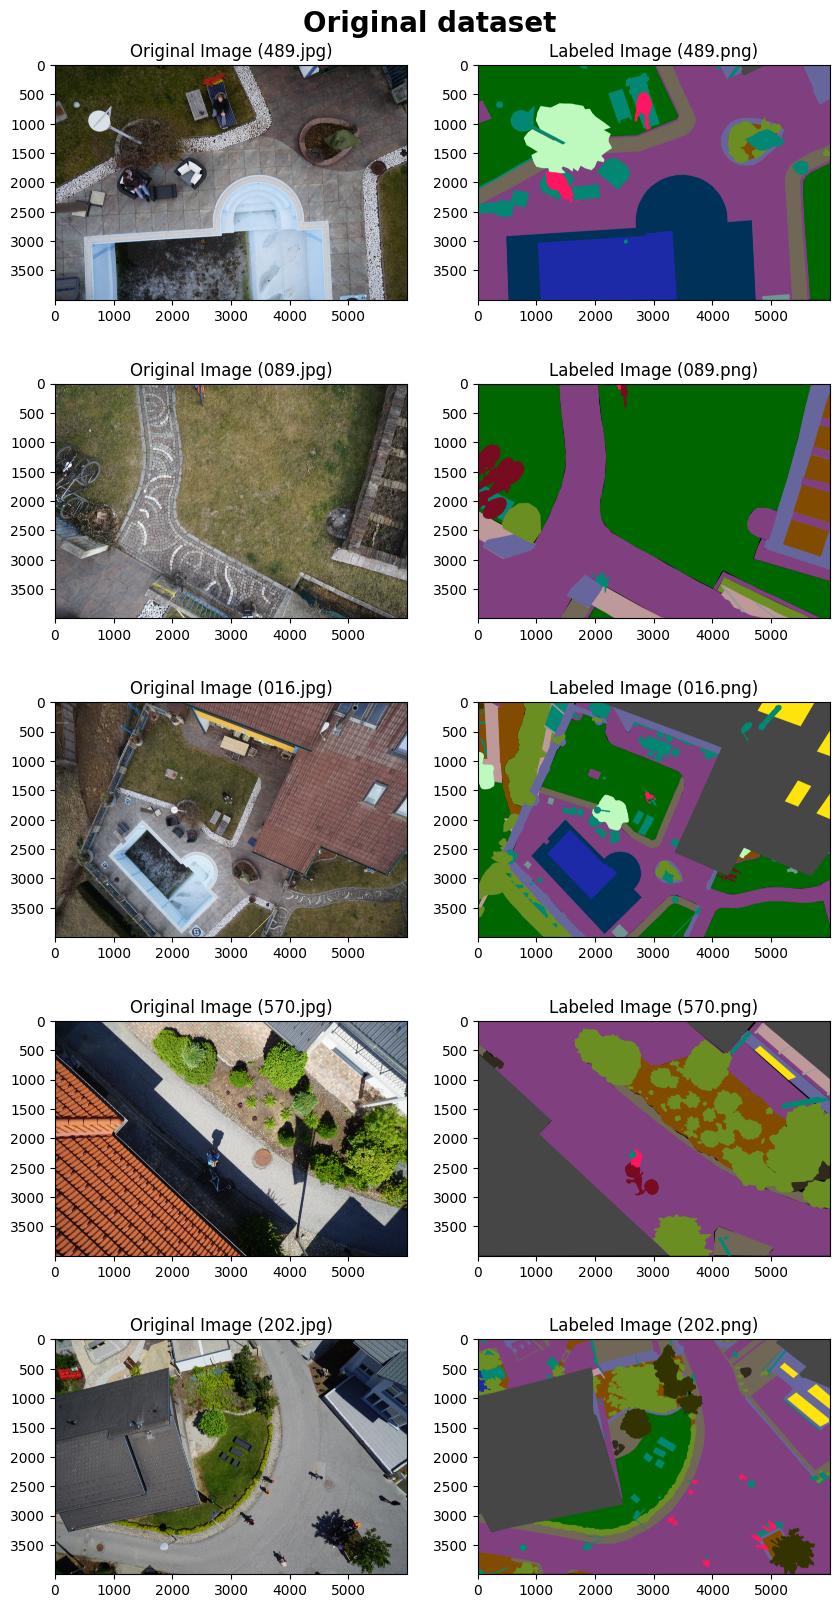

In [46]:
utils.panel_multiple_pairs(random_pairs, RAW_DIR, LABEL_DIR, 'Original dataset')

---
<a id='section_3'></a>

# 3 | Data quality

Back to [Table of contents](#section_t)

---
<a id='section_3.1'></a>

## 3.1 Image size and aspect ratios


Back to [Table of contents](#section_t)

### We use the function `utils.width_height_aspect` to extract the size and aspect ratio information

In [47]:
print(inspect.getdoc(utils.width_height_aspect))

Extract the width, height, and aspect ratio of the image dataset

Parameters
----------
path: string
    folder path where the files live

files: list of strings
    file names of the images

Returns
----------
width: list of numerical values

height: list of numerical values

aspect: list of numerical values


## Summary:

- ### Both the official version and the kaggle version have uniform image size and aspect ratios.

- ### The image size and aspect ratio differ between the official and the kaggle versions.

- ### Official version: width = 6000, height = 4000, aspect ratio = 1.5

- ### Kaggle version: width = 960, height = 736, aspect ratio = 1.3043478260869565

- ### Official dataset

In [48]:
RAW_width, RAW_height, RAW_aspect = utils.width_height_aspect(RAW_DIR, RAW_FILES)

LABEL_width, LABEL_height, LABEL_aspect = utils.width_height_aspect(LABEL_DIR, LABEL_FILES)

### Use `set` to explore the unique values in each list

In [49]:
set(RAW_width), set(RAW_height), set(RAW_aspect)

({6000}, {4000}, {1.5})

In [50]:
set(LABEL_width), set(LABEL_height), set(LABEL_aspect)

({6000}, {4000}, {1.5})

- ### Kaggle dataset

In [51]:
kaggle_raw_width, kaggle_raw_height, kaggle_raw_aspect = utils.width_height_aspect(kaggle_RAW_DIR, \
                                                                                   kaggle_RAW_FILES)
kaggle_binary_width, kaggle_binary_height, kaggle_binary_aspect = utils.width_height_aspect(kaggle_LABEL_BINARY_DIR,\
                                                                                           kaggle_LABEL_BINARY_FILES)
kaggle_multi_width, kaggle_multi_height, kaggle_multi_aspect = utils.width_height_aspect(kaggle_LABEL_MULTI_DIR,\
                                                                                        kaggle_LABEL_MULTI_FILES)

In [52]:
set(kaggle_raw_width), set(kaggle_raw_height), set(kaggle_raw_aspect)

({960}, {736}, {1.3043478260869565})

In [53]:
set(kaggle_binary_width), set(kaggle_binary_height), set(kaggle_binary_aspect)

({960}, {736}, {1.3043478260869565})

In [54]:
set(kaggle_multi_width), set(kaggle_multi_height), set(kaggle_multi_aspect)

({960}, {736}, {1.3043478260869565})

---
<a id='section_3.2'></a>

## 3.2 Class distribution


Back to [Table of contents](#section_t)

### Class imbalance is a common problem in image segmentation. We explore the class distribution by counting the total pixel numbers for each class. 

### Here, we only examine the class distribution in the Kaggle dataset.

### We use the function `utils.class_counts` 

### <span style='color:blue'>Note: When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue). Therefore, if you want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB. See [Convert BGR and RGB with Python, OpenCV (cvtColor)](https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/) </span>
  

In [55]:
print(inspect.getdoc(utils.class_counts))

Get the label counts based on the RGB match between pixels and label colors

Parameters
----------
path: string
    folder path where files live
    
files: list of strings
    each string denotes the name of an image file
    
CLASSES: list of strings
    each string denotes a class label

COLORS: list of arrays
    each array contains the RGB information for a class label

Returns
----------
sorted_label_counts: dictionary
    contains the class label and label counts across all files

    the dictionary is sorted in an descending order based on label counts


- ### Kaggle binary classes

In [56]:
kaggle_BINARY_COUNTS = utils.class_counts(kaggle_LABEL_BINARY_DIR, \
                                          kaggle_LABEL_BINARY_FILES, \
                                          kaggle_binary_CLASSES, \
                                          kaggle_binary_COLORS)

### Bar chart of class distribution

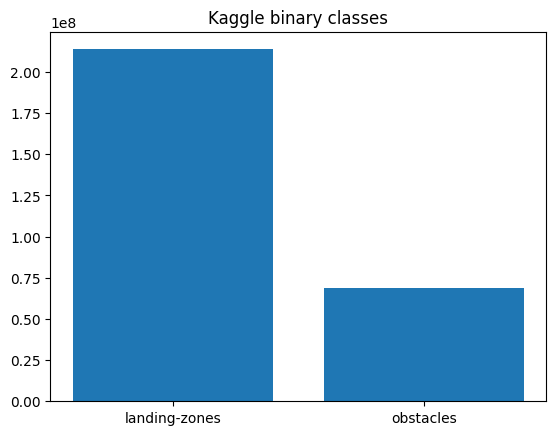

In [57]:
plt.bar(*zip(*kaggle_BINARY_COUNTS.items()))
plt.title('Kaggle binary classes')
plt.show()

### Save the dictionary 

In [58]:
kaggle_BINARY_COUNTS

with open(base_dir+"/data/DICT_kaggle_BINARY_COUNTS.txt", "w") as f:
    json.dump(kaggle_BINARY_COUNTS, f)  # encode dict into JSON

- ### Kaggle multi classes

In [59]:
kaggle_MULTI_COUNTS = utils.class_counts(kaggle_LABEL_MULTI_DIR, \
                                         kaggle_LABEL_MULTI_FILES, \
                                         kaggle_multi_CLASSES, \
                                         kaggle_multi_COLORS)

### Bar chart of class distribution

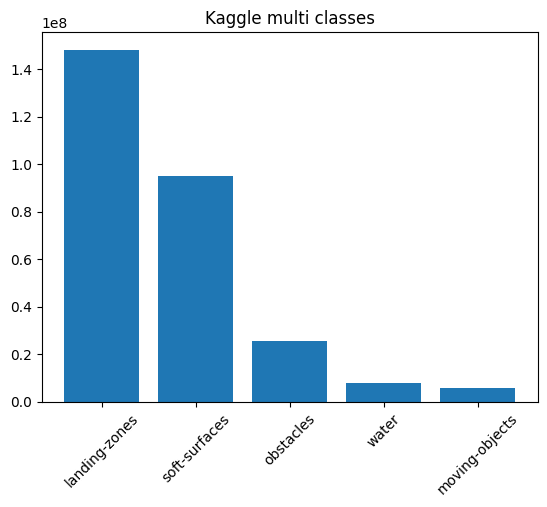

In [60]:
plt.bar(*zip(*kaggle_MULTI_COUNTS.items()))
plt.title('Kaggle multi classes')
plt.xticks(rotation=45)
plt.show()

### Save the dictionary

In [61]:
kaggle_MULTI_COUNTS
with open(base_dir+"/data/DICT_kaggle_MULTI_COUNTS.txt", "w") as f:
    json.dump(kaggle_MULTI_COUNTS, f)  # encode dict into JSON

---
<a id='section_4'></a>
# 4. Next steps

Back to [Table of contents](#section_t)

- ### Deal with the class imbalance 

- ### Data preprocessing before the model training